1. Здійсніть імпорт необхідних бібліотек.

In [1]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

2. Підготовка даних:

Завантажте набір даних Concrete Strength Prediction з платформи Kaggle.

In [2]:
from google.colab import files
import pandas as pd

# Завантаження файлу
uploaded = files.upload()

Saving ConcreteStrengthData.csv to ConcreteStrengthData (2).csv


In [3]:
df = pd.read_csv('ConcreteStrengthData.csv')
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


About Dataset
There Various Factors that affects the Strength of Concrete Such as Materials Used, Age etc.
Predict the Strength of the Concrete Based on the Components and Other Factors as Predictors.

Description of Fields are as follows:-

CementComponent:- Amount of cement is mixed

BlastFurnaceSlag:- Amount of Blast Furnace Slag is mixed

FlyAshComponent:- Amount of FlyAsh is mixed

WaterComponent:- Amount of water is mixed

SuperplasticizerComponent:- Amount of Super plasticizer is mixed

CoarseAggregateComponent:- Amount of Coarse Aggregate is mixed

FineAggregateComponent:- Amount of Coarse Aggregate is mixed

AgeInDays:- How many days it was left dry

Strength:- What was the final strength of concrete- (Target)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


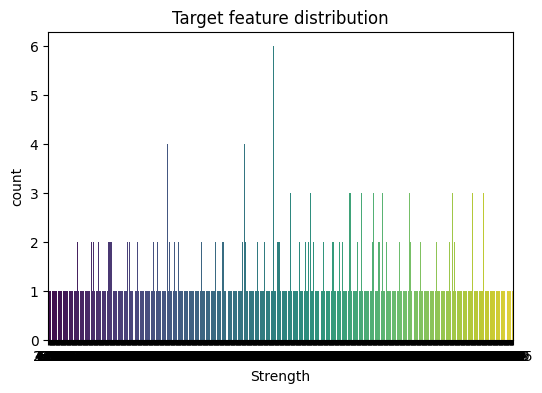

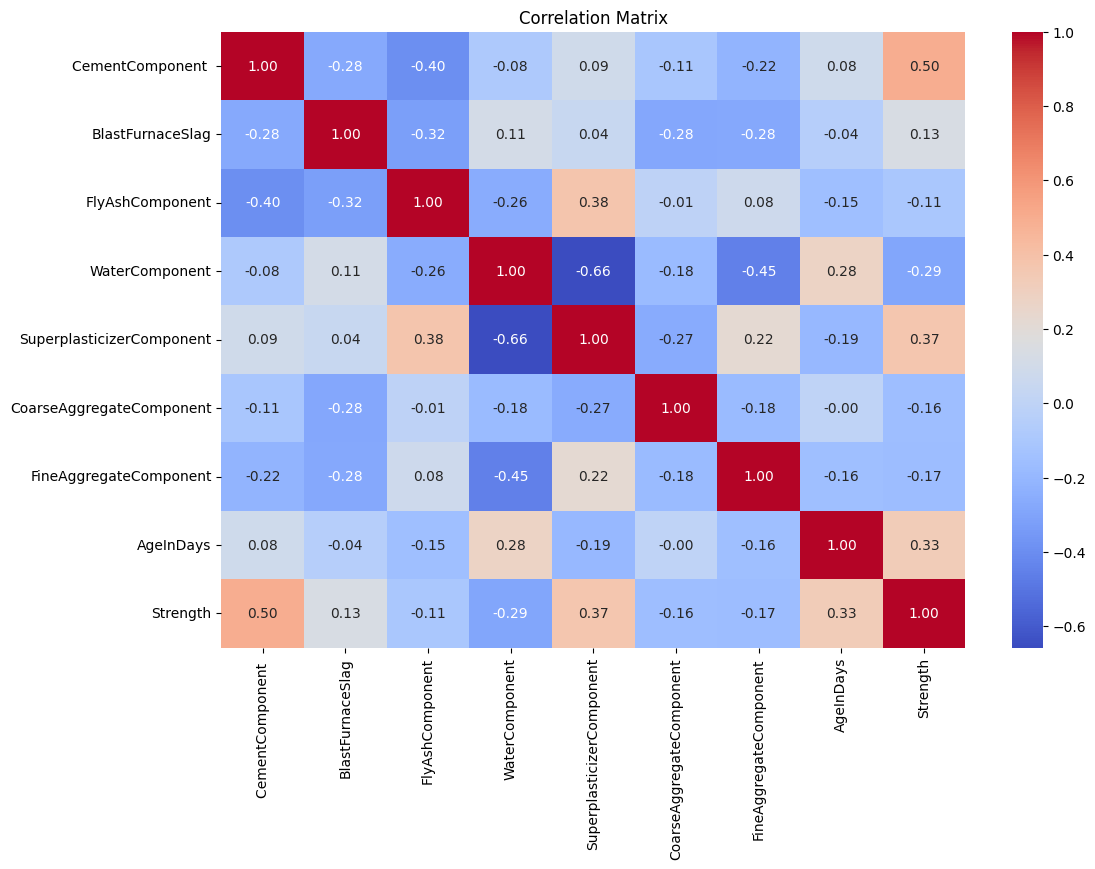

In [5]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Strength', data=df, palette='viridis')
plt.title('Target feature distribution')
plt.show()

# Visualize correlations between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [6]:
df['Strength'].describe()

,Strength
count,1030.000000
mean,35.817961
std,16.705742
min,2.330000
25%,23.710000
50%,34.445000
75%,46.135000
max,82.600000


In [7]:
cor_matrix = df.corr()
cor_matrix

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
CementComponent,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
BlastFurnaceSlag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
FlyAshComponent,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
WaterComponent,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
SuperplasticizerComponent,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
CoarseAggregateComponent,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
FineAggregateComponent,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
AgeInDays,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
Strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


In [8]:
cor_with_class = cor_matrix['Strength'].sort_values(ascending=False)
cor_with_class

,Strength
Strength,1.000000
CementComponent,0.497832
SuperplasticizerComponent,0.366079
AgeInDays,0.328873
BlastFurnaceSlag,0.134829
FlyAshComponent,-0.105755
CoarseAggregateComponent,-0.164935
FineAggregateComponent,-0.167241
WaterComponent,-0.289633


2. Підготовка даних:

Розділіть дані на ознаки (X) та цільову змінну (y).

Розділіть дані на навчальний та тестовий набори.

Нормалізуйте вхідні дані за допомогою StandardScaler.

In [4]:
# Поділимо дані на тренувальну і тестову вибірки
TARGET = 'Strength'
X = df.drop(TARGET , axis =1 )
y = df[TARGET]

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 42, test_size =0.33)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

3. Створення моделі:

Створіть клас нейронної мережі, успадкований від nn.Module.

Визначте архітектуру мережі (вхідний шар, приховані шари, вихідний шар).

In [6]:
# Оновлення індексів у y
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Визначення класу ConcreteDataset
class ConcreteDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return X, y

# Створення тренувального і тестового датасетів
train_dataset = ConcreteDataset(X_train, y_train)
test_dataset = ConcreteDataset(X_test, y_test)

# Завантаження даних пакетами
train_dataloader = DataLoader(train_dataset, batch_size=200, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=200, num_workers=4)

# Перевірка першої партії даних
batch = next(iter(train_dataloader))
print(batch)

[tensor([[-1.2470,  1.8272, -0.8006,  ...,  1.2080, -1.1914, -0.2958],
        [-0.6137, -0.8646,  1.1712,  ...,  1.3314,  0.3049, -0.5233],
        [ 0.4901, -0.8646, -0.8006,  ..., -0.0767,  0.1314,  5.1800],
        ...,
        [-0.3067, -0.8646,  0.7692,  ...,  0.1751,  1.4791, -0.7020],
        [ 0.5820, -0.8646, -0.8006,  ...,  0.9282,  0.4434, -0.2958],
        [-1.0990, -0.8646,  1.7941,  ...,  1.0757,  0.1202,  0.1592]]), tensor([37.4300, 26.0500, 38.8900, 26.1500, 11.4800, 33.0600, 15.6900, 67.3100,
        28.6300, 32.0700, 39.4500, 39.2300, 39.3800, 27.3400, 31.5400, 41.3000,
        58.8000, 45.0800, 51.7200, 55.5100, 23.8500, 68.7500, 53.1000, 15.0300,
        67.7000, 17.5800, 39.9400, 24.5000, 11.9600, 67.1100, 79.9900, 23.3500,
        33.9400, 17.5400, 13.0900, 57.2300, 19.9900, 23.7400, 44.8700, 65.2000,
        56.4000, 12.7900, 23.7000, 33.6900, 32.7200, 40.6000, 28.9900, 82.6000,
        63.5300, 17.2200, 29.8700, 71.9900, 31.2700, 52.2000, 34.6700,  6.4700,
    

4. Налаштування навчання:

Виберіть функцію втрат (наприклад, MSELoss для регресії). Обґрунтуйте вибір функції втрат.

Завдяки квадратичній природі, MSE "штрафує" великі похибки більше, ніж малі, що допомагає моделі зосередитися на великих відхиленнях. MSE найкраще працює для безперервних змінних, таких як Strength, оскільки ця змінна може приймати будь-які значення в межах діапазону (0 - 100). Має простоту у реалізації та швидку оптимізацію за допомогою градієнтного спуску.

Виберіть оптимізатор (наприклад, SGD).

Встановіть гіперпараметри — швидкість навчання (lr), розмір батчу, кількість епох.

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()

        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),

            nn.Linear(256, 128),
            torch.nn.ReLU(),

            nn.Linear(128, 64),
            torch.nn.ReLU(),

            nn.Linear(64, out_dim),
        )

    def forward(self, x):
        output = self.features(x)
        return output

In [8]:
# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

5. Навчання моделі:

Створіть цикл навчання за епохами.

У кожній епосі проходьте через навчальні дані батчами.

Обчислюйте прогнози, втрати та оновлюйте ваги моделі.

Відстежуйте та виводьте прогрес навчання.


In [9]:
num_epochs = 200

for epoch in range(num_epochs):

    # Train step

    model.train()

    y_pred_train = []

    for data in train_dataloader:
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_train.extend(outputs.cpu().detach().numpy())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train)}')
    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())

    # Eval step

    model.eval()

    y_pred_test = []

    with torch.no_grad():

        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # No backward pass

            y_pred_test.extend(outputs.cpu().detach().numpy())

        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())

Epoch [10/200], Loss: 270.9659, RMSE: 17.31321191770784
Epoch [20/200], Loss: 181.0657, RMSE: 14.289426227149738
Epoch [30/200], Loss: 151.2983, RMSE: 12.886638006844898
Epoch [40/200], Loss: 125.4480, RMSE: 11.710254814309366
Epoch [50/200], Loss: 96.8494, RMSE: 10.261576650953547
Epoch [60/200], Loss: 66.6508, RMSE: 8.474880636665858
Epoch [70/200], Loss: 47.0101, RMSE: 7.082713630412948
Epoch [80/200], Loss: 37.1781, RMSE: 6.4316943043474515
Epoch [90/200], Loss: 31.5330, RMSE: 6.058237709627496
Epoch [100/200], Loss: 27.3402, RMSE: 5.709449233749792
Epoch [110/200], Loss: 24.0481, RMSE: 5.381732176707922
Epoch [120/200], Loss: 21.2197, RMSE: 5.090255251639713
Epoch [130/200], Loss: 18.8107, RMSE: 4.825326869174853
Epoch [140/200], Loss: 17.1557, RMSE: 4.605758574806768
Epoch [150/200], Loss: 15.6854, RMSE: 4.4208729247576395
Epoch [160/200], Loss: 14.4477, RMSE: 4.256979615680757
Epoch [170/200], Loss: 13.3609, RMSE: 4.1119590624102536
Epoch [180/200], Loss: 12.4315, RMSE: 3.989327

6. Оцінка моделі:

Використовуйте навчену модель для прогнозування на тестовому наборі.

Обчисліть метрики ефективності (наприклад, MSE, MAE, R²). Обґрунтуйте вибір метрики.


Я обрала **RMSE** в якості метрики ефективності. Оскільки Strength – це безперервна змінна (міцність бетону може бути будь-яким числом від 0 до 100), RMSE підходить краще, ніж метрики для класифікації.

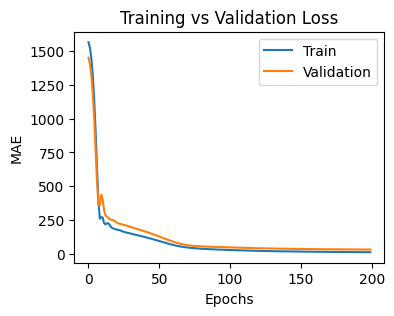

In [10]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation Loss')
plt.show()

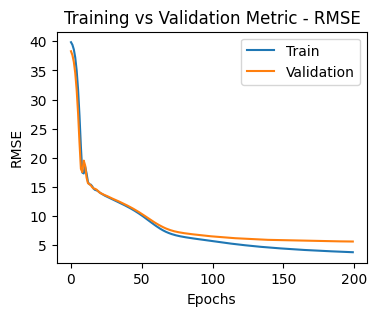

In [11]:
plt.figure(figsize=(4, 3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation Metric - RMSE')
plt.show()

7. Аналіз результатів:

Візуалізуйте фактичні та прогнозовані значення, значення функції втрат.
8. Оптимізація моделі (за потреби):

Експериментуйте з різними архітектурами мережі.
Налаштуйте гіперпараметри моделі.
9. Висновки

Зробіть висновки про навчання моделі та результати на валідаційній вибірці.

**Аналіз результатів**:

1) **learning rate = lr=1e-4:**

Epoch [10/100], Loss: 1563.8828, RMSE: 39.68827053093744

Epoch [20/100], Loss: 1494.1444, RMSE: 38.795087198910295

Epoch [30/100], Loss: 1339.8436, RMSE: 36.71827021523875

Epoch [40/100], Loss: 1078.6929, RMSE: 32.88803144263634

Epoch [50/100], Loss: 745.3817, RMSE: 27.23904702910902

Epoch [60/100], Loss: 455.1519, RMSE: 21.24392156431865

Epoch [70/100], Loss: 304.3993, RMSE: 17.619522086706045

Epoch [80/100], Loss: 252.5240, RMSE: 16.38804700913937

Epoch [90/100], Loss: 230.0313, RMSE: 15.800004482956407

Epoch [100/100], Loss: 215.9326, RMSE: 15.37834524155546

Зменшення RMSE: Значення RMSE значно зменшилось за 100 епох. Це свідчить про те, що модель навчається і стає більш точною.
Поточний рівень RMSE (~15.38): Це означає, що середня похибка прогнозів моделі становить близько 15.38 одиниць міцності бетону.

2) **lr=0.01:**
Epoch [10/100], Loss: 146.9464, RMSE: 12.282401631617772

Epoch [20/100], Loss: 51.8084, RMSE: 7.567281373062616

Epoch [30/100], Loss: 26.7030, RMSE: 5.708296197484952

Epoch [40/100], Loss: 19.2701, RMSE: 4.87662265604789

Epoch [50/100], Loss: 13.8072, RMSE: 4.303773670632122

Epoch [60/100], Loss: 11.0838, RMSE: 3.8920531992754372

Epoch [70/100], Loss: 9.3304, RMSE: 3.6129850446726177

Epoch [80/100], Loss: 7.1987, RMSE: 3.3243726334846704

Epoch [90/100], Loss: 6.1771, RMSE: 3.239157730582309

Epoch [100/100], Loss: 31.6367, RMSE: 4.798892760129717

Зменшення Loss і RMSE:

На початку навчання значення Loss і RMSE суттєво зменшуються. Це означає, що модель добре навчається і поступово покращує свої прогнози.
RMSE зменшилось з 12.28 до 3.24, що свідчить про значне покращення точності.

Аномалія в кінці навчання:

На епосі 100/100 раптово зросли Loss (до 31.64) і RMSE (до 4.80).
Це може вказувати на overfitting (перенавчання) або нестабільність навчання, наприклад, через занадто великий learning rate.


3)  **lr=0.001:**
Epoch [10/100], Loss: 246.5786, RMSE: 16.861269802786907

Epoch [20/100], Loss: 180.1167, RMSE: 14.105308929970835

Epoch [30/100], Loss: 155.5129, RMSE: 13.0442638799389

Epoch [40/100], Loss: 135.6634, RMSE: 12.169197238667875

Epoch [50/100], Loss: 114.4569, RMSE: 11.199346083903734

Epoch [60/100], Loss: 88.5938, RMSE: 9.897130946058391

Epoch [70/100], Loss: 62.8810, RMSE: 8.36361508028231

Epoch [80/100], Loss: 46.4481, RMSE: 7.1630591033140485

Epoch [90/100], Loss: 37.5680, RMSE: 6.491501522542913

Epoch [100/100], Loss: 32.4619, RMSE: 6.1152710012011475

Loss і RMSE  зменшуються, RMSE з 16.86 до 6.11, що свідчить про покращення точності. Втім, результати навчання моделі при lr=0.01 кращі. Можливо треба додати кількості епох.

4)  **lr=0.001, кількість епох = 200:**

Epoch [10/200], Loss: 270.9659, RMSE: 17.31321191770784

Epoch [20/200], Loss: 181.0657, RMSE: 14.289426227149738

Epoch [30/200], Loss: 151.2983, RMSE: 12.886638006844898

Epoch [40/200], Loss: 125.4480, RMSE: 11.710254814309366

Epoch [50/200], Loss: 96.8494, RMSE: 10.261576650953547

Epoch [60/200], Loss: 66.6508, RMSE: 8.474880636665858

Epoch [70/200], Loss: 47.0101, RMSE: 7.082713630412948

Epoch [80/200], Loss: 37.1781, RMSE: 6.4316943043474515

Epoch [90/200], Loss: 31.5330, RMSE: 6.058237709627496

Epoch [100/200], Loss: 27.3402, RMSE: 5.709449233749792

Epoch [110/200], Loss: 24.0481, RMSE: 5.381732176707922

Epoch [120/200], Loss: 21.2197, RMSE: 5.090255251639713

Epoch [130/200], Loss: 18.8107, RMSE: 4.825326869174853

Epoch [140/200], Loss: 17.1557, RMSE: 4.605758574806768

Epoch [150/200], Loss: 15.6854, RMSE: 4.4208729247576395

Epoch [160/200], Loss: 14.4477, RMSE: 4.256979615680757

Epoch [170/200], Loss: 13.3609, RMSE: 4.1119590624102536

Epoch [180/200], Loss: 12.4315, RMSE: 3.989327607638287

Epoch [190/200], Loss: 11.6256, RMSE: 3.8816954748511905

Epoch [200/200], Loss: 10.8996, RMSE: 3.7823459997579176

Я вирішила обрати ці налаштування, що показують стабільне навчання та покращення результатів.

